### Name: Zhornichenko Ilya Alekseevich
### Group: TMSS
### Higher school of economics

## Code from seminar noetbook ##

In [1]:
from __future__ import print_function
#import util
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
### Here goes our main class: a layer that can .forward() and .backward().

In [3]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        # <your code. Try np.maximum>
        return np.maximum(input, 0)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad  

In [5]:
# some tests
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = ReLU()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

In [6]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <x*W> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers. We use normal initialization, 
        # but surely there is something better. Try this once you got it working: http://bit.ly/2vTlmaJ
        self.weights = np.random.randn(input_units, output_units)*0.01
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <x*W> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = grad_output @ np.transpose(self.weights)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.transpose(input) @ grad_output
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

In [7]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [8]:
# To test the grads, we use gradients obtained via finite differences

from util import eval_numerical_gradient

x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [9]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


In [10]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [11]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

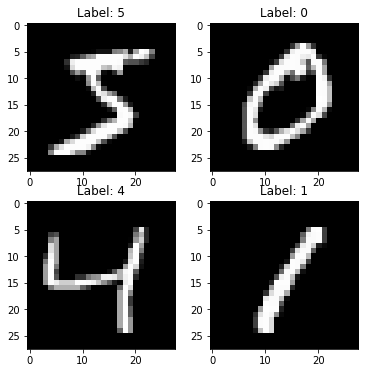

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [13]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 10))

In [14]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    
    input = X
    activations = [input]
    for i in range(len(network)):
      previous = activations[i]
      activations.append(network[i].forward(previous))
    # ha = network[0].forward(input)
    # hb = network[1].forward(ha)
    # hc = network[2].forward(hb)
    # activations = [ha, hb, hc]
    activations.pop(0)
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)

In [15]:
def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    You can estimate loss and loss_grad, obtaining dL / dy_pred
    Then you can run layer.backward going from last layer to first, 
    propagating the gradient of input to previous layers.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X] + layer_activations  #layer_input[i] is an input for network[i]
    # X, ha, hb, hc = layer_inputs
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    # loss_grad_wrt_hc = loss_grad
    loss_grad_wrt = [loss_grad]
    for i in range(len(layer_inputs) - 2, -1, -1):
      previous = loss_grad_wrt[len(layer_inputs) -2 - i]
      loss_grad_wrt.append(network[i].backward(layer_inputs[i] ,previous))

    # loss_grad_wrt_hb = network[2].backward(hb, loss_grad_wrt_hc)
    # loss_grad_wrt_ha = network[1].backward(ha, loss_grad_wrt_hb)
    # loss_grad_wrt_x = network[0].backward(X, loss_grad_wrt_ha)
    
    # propagate gradients through network layers using .backward
    # hint: start from last layer and move to earlier layers
    #<YOUR CODE>
        
    return np.mean(loss)

In [16]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [17]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 0.99962
Val accuracy: 0.9807


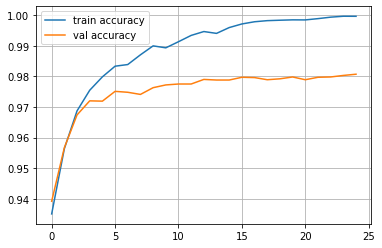

In [18]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

##My implementations##

### My sigmoid implementation ###

In [20]:
class Sigmoid(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        return 1/(1 + np.exp(-1*input))
    
    def backward(self, input, grad_output):
      sigmoid_grad = self.forward(input)*(-1*self.forward(input) + 1)
      return grad_output*sigmoid_grad  

In [21]:
from util import eval_numerical_gradient
x = np.linspace(-1,1,10*32).reshape([10,32])
l = Sigmoid()
grads = l.backward(x,np.ones([10,32])/(32*10))
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=x)
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0),\
    "gradient returned by your layer does not match the numerically computed gradient"

In [22]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(Sigmoid())
network.append(Dense(100, 10))

In [23]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 49
Train accuracy: 0.9949
Val accuracy: 0.9771


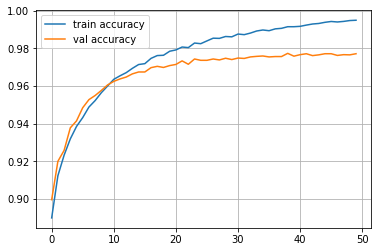

In [24]:
for epoch in range(50):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

the nonlinearities requires more epoch to reach the same accurasy compared to linear activation. also we can notice that with nonlinear activatiion fuction we can get more smooth learning curve and have more restancy to overfitting. 

In [25]:
network = []
network.append(Dense(X_train.shape[1], 100))
network.append(ReLU())
network.append(Dense(100, 100))
network.append(ReLU())
network.append(Dense(100, 10))

In [129]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 24
Train accuracy: 1.0
Val accuracy: 0.9788


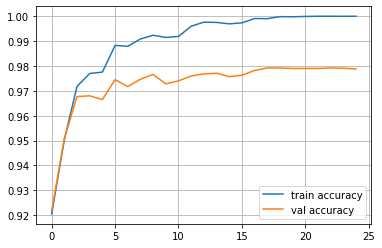

In [130]:
for epoch in range(25):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()